# Sessió 3: PyTorch & Classificació Avançada

## **NOM**: ####

## **NIU**: ####

En aquesta sessió continuarem utilitzant pytorch per definir i evaluar diferents models amb xarxes neuronals.

* Durant la classe, repasarem el codi aqui mostrat i veurem què podem provar.
* **A casa**
 * Definir models i entrenar-los (5pts)
 * Mostrar corbes de aprenentatge (2pts)
 * Mostrar models, parametres, flops teorics i temps real dels models (3pts)

Treballarem sobre la base de dades [Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist). És similar a la base de dades de MNIST, un dataset clàssic en la visió per computador. Són imatges de 28x28 pixels i en escala de grisos. El original disposa de 60.000 imatges de entrenament i 10.000 de test. Està anotat en 10 categories diferents:

|Id|Nom|
|:-:|:--|
|0|T-shirt/top
|1|Trouser |
|2|Pullover|
|3|Dress|
|4|Coat|
|5|Sandal|
|6|Shirt|
|7|Sneaker|
|8|Bag |
|9|Ankle boot|

<img src="https://github.com/zalandoresearch/fashion-mnist/raw/master/doc/img/fashion-mnist-sprite.png" width="60%">


### Imports

In [1]:
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
import torch.nn.functional as F
import tqdm
import sys
import time
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

### Parameters

Aqui definim els principals parametres que poden fer variar el metode

In [2]:
quick_experiment = True  # reduce the number of training and testing samples for a quick check
epochs_in_quick = 3      # number of epochs in the fast experiment
n_train_in_quick = 600  # number of training images in the fast experiment
n_test_in_quick = 1000    # number of testing images in the fast experiment

epochs = 5             # number of epochs to train (default: 14)
learning_rate = 0.001   # learning rate (default: 0.001-[0.01]-0.1)

Si fem un experiment rapid, quin % del total estem agafant:

In [3]:
total_training_data = 60000 # no tocar. només serveix per visualitzar
total_testing_data = 10000  # no tocar. només serveix per visualitzar

print("TRAINING USED:  {:.1f}%\nTESTING  USED:  {:.1f}%".format(100.*n_train_in_quick/total_training_data, 
                                                                100.*n_test_in_quick/total_testing_data))

TRAINING USED:  1.0%
TESTING  USED:  10.0%


En principi els següents parametres son força estandard i no caldria tocar-los gaire si no sabeu el que volen dir.

In [4]:
batch_size = 100        # number of samples during training
test_batch_size = 1000  # number of samples for test 

no_cuda = True          # disables CUDA training
dry_run = False         # quickly check a single pass
seed = 1                # random seed (default: 1)
log_interval = 50       # how many batches to wait before logging training status
save_model = False      # For Saving the current Model


# Check if cuda is available
use_cuda = not no_cuda and torch.cuda.is_available()
print(f"USING CUDA: {use_cuda}")
torch.manual_seed(seed)

# define the device where to compute (cpu or gpu)
device = torch.device("cuda" if use_cuda else "cpu")

train_kwargs = {'batch_size': batch_size}
test_kwargs = {'batch_size': test_batch_size}
if use_cuda:
    cuda_kwargs = {'num_workers': 1,
                   'pin_memory': True,
                   'shuffle': True}
    train_kwargs.update(cuda_kwargs)
    test_kwargs.update(cuda_kwargs)


USING CUDA: False


### Models

In [5]:

class Net_Linear(nn.Module):
    def __init__(self):
        super(Net_Linear, self).__init__()
        self.w = nn.Linear(784, 10)

    def forward(self, x):
        x = torch.flatten(x, 1)
        output = self.w(x)
        return F.log_softmax(output, dim=1)


class LeNet_tiny(nn.Module):
    def __init__(self):
        super(LeNet_tiny, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 3, 1)
        self.conv2 = nn.Conv2d(8, 16, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(2304, 32)
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output


class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output


class FashionCNN(nn.Module):

    def __init__(self):
        super(FashionCNN, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.fc1 = nn.Linear(in_features=64 * 6 * 6, out_features=600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=10)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)

        return out

### Models a definir

In [6]:
#class my_model_1(nn.Module):
#..

#class my_model_2(nn.Module):
#..

#class my_model_3(nn.Module):
#..


### Funcions auxiliars

In [7]:
def visualize_confusion_matrix(y_pred, y_real):
    # mostra la matriu de confusió
    cm = confusion_matrix(y_real, y_pred)
    plt.subplots(figsize=(10, 6))
    sns.heatmap(cm, annot = True, fmt = 'g')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

def calcular_parametres_del_model(current_model):
    pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print("# trainable parameters: {:,}".format(pytorch_total_params))
    return pytorch_total_params

def calculate_parameters_and_flops(current_model):
    from thop import profile
    test_input = torch.randn(1, 1, 28, 28)
    macs, params = profile(current_model, inputs=(test_input,))  # multiply accumulate operation (GFLOPS = 2 * GMACS)
    # normalment, en gpus i exemples reals, es parlaria minim de Gigaflops.
    # print("%s | %.2f Params(M) | %.3f FLOPs(G)" % (current_model._get_name(), params / (1000 ** 2), macs / (1000 ** 3)))
    print("%s | %.2f Params(M) | %.3f FLOPs(M)" % (current_model._get_name(), params / (1000 ** 2), macs / (1000 ** 2)))
    return macs, params
    
def mostra_estructura_model_torchviz(current_model):
    from torchviz import make_dot
    test_input = torch.randn(1, 1, 28, 28)
    return make_dot(current_model(test_input), params=dict(current_model.named_parameters()))
    
    
def mostra_estructura_model_hiddenlayer(current_model):
    import hiddenlayer as hl
    test_input = torch.randn(1, 1, 28, 28)
    hl_graph = hl.build_graph(current_model, test_input)
    return hl_graph



### Train loop

In [8]:
def train(model, device, train_loader, optimizer, criterion):
    losses = []
    model.train()
    t = tqdm.tqdm(enumerate(train_loader), total=len(train_loader))
    t.set_description('Train')
    for batch_idx, (data, target) in t:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        t.set_postfix(loss=loss.item())

    return losses

### Test loop

In [9]:
def test(model, device, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    totals = 0
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        t = tqdm.tqdm(test_loader, total=len(test_loader))
        t.set_description('Test ')
        for data, target in t:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item() * data.shape[0]  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            totals += len(target)
            t.set_postfix(loss=test_loss/totals, accuracy=100.*correct/totals)
            all_preds.extend(np.asarray(pred))
            all_targets.extend(np.asarray(target))

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    
    # visualize confusion matrix?
    
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset), accuracy))
    return test_loss, accuracy

### Preparar les dades d'entrenament

In [10]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.1307,), (0.3081,))
])
dataset_train = torchvision.datasets.FashionMNIST('../data', train=True, download=True, transform=transform)
dataset_val = torchvision.datasets.FashionMNIST('../data', train=False, transform=transform)

if quick_experiment:
    epochs = epochs_in_quick
    n_not_used_for_train_in_quick = len(dataset_train) - n_train_in_quick
    dataset_train, dataset_train_not_used = torch.utils.data.random_split(dataset_train,
                                                                          [n_train_in_quick,
                                                                           n_not_used_for_train_in_quick])

    n_not_used_for_test_in_quick = len(dataset_val) - n_test_in_quick
    dataset_val, dataset_val_not_used = torch.utils.data.random_split(dataset_val,
                                                                          [n_test_in_quick,
                                                                           n_not_used_for_test_in_quick])

train_loader = torch.utils.data.DataLoader(dataset_train, **train_kwargs)
test_loader = torch.utils.data.DataLoader(dataset_val, **test_kwargs)


26422272it [00:01, 14573566.70it/s]                              


Extracting ../data\FashionMNIST\raw\train-images-idx3-ubyte.gz to ../data\FashionMNIST\raw



29696it [00:00, 101050.43it/s]                          


Extracting ../data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to ../data\FashionMNIST\raw



4422656it [00:00, 7612193.38it/s]                              


Extracting ../data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ../data\FashionMNIST\raw



6144it [00:00, 3094728.45it/s]          

Extracting ../data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ../data\FashionMNIST\raw



### Experiment Loop

In [11]:
def experiment(model, device, loss, optimizer, train_loader, test_loader, name='', save_model=False):
    init_time = time.time()
    losses_train = []
    losses_test = []
    accuracies_test = []
    print('--'*50)
    print('STARTING EXPERIMENT {}'.format(name))
    print('--'*50)
    
    model.to(device)
    print("CHECKING INITIAL TEST LOSS (with random weights..)")
    # calculo aquest test tan sols per visualitzar més maca la gràfica de losses. No caldria utilitzar-lo
    loss_test_epoch, accuracy_epoch = test(model, device, test_loader, loss)
    losses_test.append(loss_test_epoch)
    accuracies_test.append(accuracy_epoch)
    
    for epoch in range(1, epochs + 1):
        print ("EPOCH {}".format(epoch))
        sys.stdout.flush()
        loss_train_epoch = train(model, device, train_loader, optimizer, loss)
        loss_test_epoch, accuracy_epoch = test(model, device, test_loader, loss)

        losses_train.extend(loss_train_epoch)
        losses_test.append(loss_test_epoch)
        accuracies_test.append(accuracy_epoch)

    plt.plot(range(len(losses_train)), 
             losses_train, label="Training Loss")

    plt.plot(range(0, len(losses_train)+1, int(len(losses_train)/(len(losses_test)-1))), 
             losses_test, label="Test Loss")
    plt.legend()
    plt.show()
    
    elapsed = time.time()-init_time

    if save_model:
        torch.save(model.state_dict(), "fashion_mnist_cnn.pt")

    print ("ELAPSED TIME: {:.1f}s".format(elapsed))

    return losses_train, losses_test, accuracies_test, elapsed

### Instanciació d'un model

In [12]:
model = LeNet()
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

### Fer un entrenament

Test :   0%|          | 0/1 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
STARTING EXPERIMENT EXP #1
----------------------------------------------------------------------------------------------------
CHECKING INITIAL TEST LOSS (with random weights..)


Test : 100%|██████████| 1/1 [00:07<00:00,  7.16s/it, accuracy=12.3, loss=2.31]


Test set: Average loss: 2.3115, Accuracy: 123/1000 (12.30%)

EPOCH 1



Test : 100%|██████████| 1/1 [00:00<00:00,  1.03it/s, accuracy=64.7, loss=1.24]


Test set: Average loss: 1.2423, Accuracy: 647/1000 (64.70%)

EPOCH 2



Test : 100%|██████████| 1/1 [00:00<00:00,  1.29it/s, accuracy=71.1, loss=0.89]


Test set: Average loss: 0.8905, Accuracy: 711/1000 (71.10%)

EPOCH 3



Test : 100%|██████████| 1/1 [00:00<00:00,  1.24it/s, accuracy=74.4, loss=0.742]



Test set: Average loss: 0.7423, Accuracy: 744/1000 (74.40%)



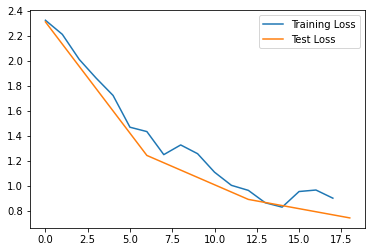

ELAPSED TIME: 29.9s


In [13]:
loss_train, loss_test, acc_test, elapsed = experiment(model, 
                                                      device, 
                                                      loss, 
                                                      optimizer, 
                                                      train_loader, 
                                                      test_loader, 
                                                      name='EXP #1', 
                                                      save_model=False)

# Entrega

* A. Fes varis entrenaments amb diferents models.**(5pts)**
 * Utilitza els 4 models aqui definits.
 * **Defineix 3 nous models diferents, explica'ls i entrena'ls.** Pots crear-ne de simples, de més complexes, treure poolings o afegir-ne, modificar el percentatge de regularització del dropout, cambiar la funció d’activació, buscar altres definicions per Internet, altres tipus de capes, amb més o menys neurones per capa, capes residuals, provar d’agafar-ne alguna de pre-entrenada… Podeu provar altres configuracions d’entrenament, més o menys èpoques, diferent learning rate, diferent optimitzador, afegir weight_decay….


* B. **Mostra les corbes d'aprenentatge** de cadascún d'ells i compara-les amb les aquí definides. (7 en total) **(2pts)**
 * Per cada model, mostra la loss d'entrenament i la de test en una mateixa gráfica.
 * Mostra les matrius de confusió del model de la última època sobre el conjunt de test.
 
* C. **Mostra els models**, parametres, flops teorics i temps real dels models **(3pts)**
 * Us he deixat varies funcions que us mostren els models. Haureu d'instalar les llibreries corresponents: 
   * [thop](https://github.com/Lyken17/pytorch-OpCounter/) per mostrar parametres, flops..
   * [hiddenlayer](https://github.com/waleedka/hiddenlayer) i [torchviz](https://github.com/szagoruyko/pytorchviz). Per mostrar els graphs. Aquestes també requereixen tenir instalat ``graphviz``